# Import Section

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
#tools and modelization
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import isnan
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

#plotting 
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

/kaggle/input/nfl-big-data-bowl-2021/week11.csv
/kaggle/input/nfl-big-data-bowl-2021/week14.csv
/kaggle/input/nfl-big-data-bowl-2021/week12.csv
/kaggle/input/nfl-big-data-bowl-2021/week9.csv
/kaggle/input/nfl-big-data-bowl-2021/week16.csv
/kaggle/input/nfl-big-data-bowl-2021/week10.csv
/kaggle/input/nfl-big-data-bowl-2021/week7.csv
/kaggle/input/nfl-big-data-bowl-2021/week17.csv
/kaggle/input/nfl-big-data-bowl-2021/week1.csv
/kaggle/input/nfl-big-data-bowl-2021/week15.csv
/kaggle/input/nfl-big-data-bowl-2021/week4.csv
/kaggle/input/nfl-big-data-bowl-2021/week13.csv
/kaggle/input/nfl-big-data-bowl-2021/games.csv
/kaggle/input/nfl-big-data-bowl-2021/plays.csv
/kaggle/input/nfl-big-data-bowl-2021/week2.csv
/kaggle/input/nfl-big-data-bowl-2021/players.csv
/kaggle/input/nfl-big-data-bowl-2021/week5.csv
/kaggle/input/nfl-big-data-bowl-2021/week6.csv
/kaggle/input/nfl-big-data-bowl-2021/week8.csv
/kaggle/input/nfl-big-data-bowl-2021/week3.csv


# Constants Section

In [2]:
team_abbr_correspondance = {'Arizona Cardinals':'ARZ', 'Miami Dolphins':'MIA', 'Atlanta Falcons':'ATL', 'Minnesota Vikings':'MIN',
                            'Baltimore Ravens':'BLT', 'New England Patriots':'NE', 'Buffalo Bills':'BUF', 'New Orleans Saints':'NO',
                            'Carolina Panthers':'CAR', 'New York Giants':'NYG', 'Chicago Bears':'CHI', 'New York Jets':'NYJ',
                            'Cincinnati Bengals':'CIN', 'Oakland Raiders':'OAK', 'Cleveland Browns':'CLV', 'Philadelphia Eagles':'PHI',
                            'Dallas Cowboys':'DAL', 'Pittsburgh Steelers':'PIT', 'Denver Broncos':'DEN', 'St. Louis Rams':'STL', 
                            'Detroit Lions':'DET', 'San Diego Chargers':'SD', 'Green Bay Packers':'GB', 'San Francisco 49ers':'SF',
                            'Houston Texans':'HOU', 'Seattle Seahawks':'SEA', 'Indianapolis Colts':'IND', 'Tampa Bay Buccaneers':'TB',
                            'Jacksonville Jaguars':'JAX', 'Tennessee Titans':'TEN', 'Kansas City Chiefs':'KC', 'Washington Redskins':'WAS'}


foul_abbr_correspondance = {'Chop Block':'CHB', 'Illegal Substitution':'ILS', 'Clipping':'CLP', 'Illegal Touch—Kick':'ITK',
                            'Defensive Delay of Game':'DOD', 'Illegal Touch—Pass':'ITP', 'Defensive Holding':'DH', 'Illegal Use of Hands':'ILH',
                            'Defensive Offside':'DOF', 'Ineligible Downfield Kick':'IDK', 'Defensive Pass Interference':'DPI', 'Ineligible Downfield Pass':'IDP',
                            'Defensive Too Many Men on Field':'DTM', 'Intentional Grounding':'ING', 'Delay of Game':'DOG', 'Invalid Fair Catch Signal':'IFC',
                            'Delay of Kickoff':'DOK', 'Horse Collar':'HC', 'Disqualification':'DSQ', 'Kickoff Out of Bounds':'KOB',
                            'Encroachment' :'ENC', 'Leaping':'LEA', 'Facemask (15 Yards)':'FMM' ,'Leverage':'LEV', 'Fair Catch Interference':'FCI' ,'Low Block':'LBL',
                            'False Start':'FST', 'Neutral Zone Infraction':'NZI', 'Illegal Bat':'BAT', 'Offensive Holding':'OH', 
                            'Illegal Blindside Block': 'BLI' ,'Offensive Offside' :'OOF', 'Illegal Block Above the Waist':'IBW', 'Offensive Pass Interference':'OPI',
                            'Illegal Contact':'ICT', 'Offensive Too Many Men on Field':'OTM',
                            'Illegal Crackback':'ICB', 'Offside on Free Kick':'OFK', 'Illegal Cut':'ICU', 'Player Out of Bounds on Punt':'POP',
                            'Illegal Formation':'ILF', 'Roughing the Kicker':'RRK', 'Illegal Forward Handling':'IFH', 'Roughing the Passer':'RPS',
                            'Illegal Forward Pass':'IFP', 'Running into the Kicker':'RNK', 'Illegal Kick':'KIK', 'Short Free Kick':'SFK', 
                            'Illegal Motion':'ILM', 'Taunting':'TAU', 'Illegal Peel Back':'IPB', 'Tripping':'TRP', 'Illegal Shift':'ISH', 'Unnecessary Roughness':'UNR',
                            'Unsportsmanlike Conduct':'UNS'}

routes = ['ANGLE', 'CORNER', 'CROSS', 'FLAT', 'GO', 'HITCH', 'IN', 'OUT', 'POST', 'SCREEN', 'SLANT', 'WHEEL']

# Useful Functions' Section

In [3]:
def decide_playType(x):
    if(x in ['C', 'I', 'IN']):
        return 'play_type_pass'
    elif(x == 'S'):
        return 'play_type_sack'
    else:
        return 'play_type_unknown'
    
def calculate_timeLeft(x):
    try:
        minutes = int(x[x.find('(')+1: x.find(':')])
    except:
        minutes = 0
    
    try:
        seconds = int(x[x.find(':')+1: x.find(')')])
    except:
        seconds = 0
    return minutes*60+seconds

def isPenalty(x, side):
    #constants
    defensive_pena = ['DH', 'DPI', 'DOF', 'DTM' ]
    offensive_pena = ['OH', 'OPI', 'DOG', 'DOK', 'ING']
    
    d_pena, o_pena = False, False
    try:
        x = x.split(';')
        if(any(('d' in pena) and (pena in defensive_pena) for pena in x)):
            d_pena = True

        if(any(pena in offensive_pena for pena in x)):
            o_pena = True
    except:
        pass
    if(side == 'D'):        
        return d_pena
    else:
        return o_pena
    
def isSuccessfulPlay(x):
    return 'S' if(x[2] == 'C' and not(x[0]) and not(x[1])) else 'NS'  #need to recheck the definition of a successful play

def defenderTeam(x, games):
    if(pass_games.loc[x[0], 'home'] == x[1]):
        return pass_games.loc[x[0], 'away']
    else:
        return pass_games.loc[x[0], 'home']

def get_nbr_players(x):
    try:
        x = x.strip()
        return int(x.split(' ')[0])
    except:
        return 0

In [4]:
#go to https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position to get this function
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(-5, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

# Analysis Section

## ***Players:***

In [5]:
players = pd.read_csv("/kaggle/input/nfl-big-data-bowl-2021/players.csv")
players.set_index('nflId', inplace=True)
players.height = players.height.apply(lambda x:int(x) if ('-' not in str(x)) else int(x[0:1])*12 + int(x[2:]))
players.birthDate = players.birthDate.apply(lambda x: x if('-' in x) else x[6:]+'-'+x[0:2]+'-'+x[3:5])
players.birthDate = pd.to_datetime(players.birthDate)
players['age'] = pd.to_datetime('now').year - players.birthDate.dt.year
reordered_columns = ['displayName', 'birthDate', 'age', 'height', 'weight', 'position', 'collegeName']
players = players[reordered_columns]
players.head()

,displayName,birthDate,age,height,weight,position,collegeName
nflId,,,,,,,
2539334,Desmond Trufant,1990-09-10,30,72,190,CB,Washington
2539653,Robert Alford,1988-11-01,32,70,186,CB,Southeastern Louisiana
2543850,Ricardo Allen,1991-12-18,29,69,186,SS,Purdue
2555162,Deion Jones,1994-11-04,26,73,227,MLB,Louisiana State
2555255,De'Vondre Campbell,1993-07-01,27,75,232,OLB,Minnesota


In [6]:
pos_hist = px.histogram(players, x='position', title="Players' positions Distribution")
pos_hist.show()

In [7]:
w_hist = px.histogram(players, x='weight', title="Players' weight Distribution")
w_hist.show()

In [8]:
h_hist = px.histogram(players, x='height', title="Players' height Distribution")
h_hist.show()

In [9]:
age_hist = px.histogram(players, x='age', title="Players' age Distribution")
age_hist.show()

## ***Games:***

In [10]:
games = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2021/games.csv')
games.set_index('gameId', inplace=True)
games.week = games.week.apply(lambda x: 'week_'+str(x))
games.head()

,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,week
gameId,,,,,
2018090600,09/06/2018,20:20:00,PHI,ATL,week_1
2018090901,09/09/2018,13:00:00,CLE,PIT,week_1
2018090902,09/09/2018,13:00:00,IND,CIN,week_1
2018090903,09/09/2018,13:00:00,MIA,TEN,week_1
2018090900,09/09/2018,13:00:00,BAL,BUF,week_1


In [11]:
gpw_hist = px.histogram(games, x='week', title="Number of games per week")
gpw_hist.show()

## ***Plays:***

In [12]:
columns_to_keep = ['timeLeft', 'quarter', 'down', 'possessionTeam', 'offenseFormation', 'personnelO', 'defendersInTheBox',
                   'personnelD', 'playType', 'yardsToGo', 'numberOfPassRushers', 'typeDropback', 'preSnapHomeScore', 
                   'preSnapVisitorScore', 'offensePlayResult', 'playResult', 'epa', 'isDefensivePenalty', 'isOffensivePenalty',
                   'isSuccessfulPlay', 'passResult']

plays = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2021/plays.csv')
plays.playType = plays.passResult.apply(lambda x: decide_playType(x))
plays['timeLeft'] = plays.playDescription.apply(lambda x: calculate_timeLeft(x))
plays['isDefensivePenalty'] = plays.penaltyCodes.apply(lambda x: isPenalty(x, 'D'))
plays['isOffensivePenalty'] = plays.penaltyCodes.apply(lambda x: isPenalty(x, 'O'))
plays = plays[plays.passResult.notna()]
plays['isSuccessfulPlay'] = plays[['isOffensivePenalty', 'isDefensivePenalty', 'passResult']].apply(lambda x:isSuccessfulPlay(x), axis=1)
plays.set_index(['gameId', 'playId'], inplace=True)
plays = plays[columns_to_keep]
plays

timeLeft  quarter  down possessionTeam offenseFormation  \
gameId     playId                                                            
2018090600 75           900        1     1            ATL           I_FORM   
           146          790        1     1            ATL       SINGLEBACK   
           168          785        1     2            ATL          SHOTGUN   
           190          781        1     3            ATL          SHOTGUN   
           256          659        1     3            ATL          SHOTGUN   
...                     ...      ...   ...            ...              ...   
2018122200 2300         473        3     2            WAS       SINGLEBACK   
           3177         413        4     3            TEN          SHOTGUN   
2018122201 566          332        1     3            LAC          SHOTGUN   
           1719          68        2     3            LAC       SINGLEBACK   
           2649         436        3     1            BAL          SHOTGUN   

                         personnelO  defendersInTheBox        personnelD  \
gameId     playId                                                          
2018090600 75      2 RB, 1 TE, 2 WR                7.0  4 DL, 2 LB, 5 DB   
           146     1 RB, 1 TE, 3 WR                7.0  4 DL, 2 LB, 5 DB   
           168     2 RB, 1 TE, 2 WR                6.0  4 DL, 2 LB, 5 DB   
           190     1 RB, 1 TE, 3 WR                6.0  4 DL, 1 LB, 6 DB   
           256     2 RB, 3 TE, 0 WR                8.0  6 DL, 3 LB, 2 DB   
...                             ...                ...               ...   
2018122200 2300    1 RB, 1 TE, 3 WR                7.0  2 DL, 4 LB, 5 DB   
           3177    1 RB, 1 TE, 3 WR                6.0  2 DL, 4 LB, 5 DB   
2018122201 566     1 RB, 1 TE, 3 WR                6.0  1 DL, 5 LB, 5 DB   
           1719    1 RB, 1 TE, 3 WR                7.0  2 DL, 3 LB, 6 DB   
           2649    1 RB, 1 TE, 3 WR                6.0  4 DL, 1 LB, 6 DB   

                         playType  yardsToGo  ...           typeDropback  \
gameId     playId                             ...                          
2018090600 75      play_type_pass         15  ...            TRADITIONAL   
           146     play_type_pass         10  ...            TRADITIONAL   
           168     play_type_pass         10  ...            TRADITIONAL   
           190     play_type_pass         10  ...  SCRAMBLE_ROLLOUT_LEFT   
           256     play_type_pass          1  ...            TRADITIONAL   
...                           ...        ...  ...                    ...   
2018122200 2300    play_type_pass          5  ...                    NaN   
           3177    play_type_pass          7  ...                    NaN   
2018122201 566     play_type_pass          4  ...                    NaN   
           1719    play_type_pass          1  ...                    NaN   
           2649    play_type_pass         10  ...                    NaN   

                  preSnapHomeScore  preSnapVisitorScore  offensePlayResult  \
gameId     playId                                                            
2018090600 75                  0.0                  0.0                 10   
           146                 0.0                  0.0                  0   
           168                 0.0                  0.0                  0   
           190                 0.0                  0.0                 33   
           256                 0.0                  0.0                  0   
...                            ...                  ...                ...   
2018122200 2300                NaN                  NaN                  0   
           3177                NaN                  NaN                  0   
2018122201 566                 NaN                  NaN                 27   
           1719                NaN                  NaN                  0   
           2649                NaN                  NaN                  0   

           

In [13]:
plays_ = plays.copy().reset_index(drop=False)
plays_.gameId = plays_.gameId.apply(lambda x: 'game_'+str(x))
nbr_succ_plays_per_game = px.histogram(plays_, x='gameId', color='isSuccessfulPlay', title="Number of Successful plays per game")
nbr_succ_plays_per_game.show()

In [14]:
plays_.dropna(subset=['offenseFormation'], axis=0, inplace=True)
formation_distribution_per_game = px.histogram(plays_, x="gameId", color="offenseFormation", title="Distribution of offensive formation's types per game")
formation_distribution_per_game.show()

=> The SHOTGUN formation tend to be the mostly used offense formation in games

In [15]:
list_figs = []
for formation in plays_.offenseFormation.unique():
    temp = plays_[plays_.offenseFormation == formation].copy()
    list_figs.append(px.histogram(temp, x="gameId", color="isSuccessfulPlay", 
                                             title=f"Number of Successful plays per game with {formation} offensive formation"))

In [16]:
np.random.choice(list_figs).show()

A binary-classifier on predicting whether a pass would be completed or not depending on the list of element below :
* possesion and defender teams
* Offensive and defensive personnel
* Offensive formation
* quarter and down
* yards to go

This classifier doesn't take into penalties occuring

In [17]:
#we take only pass plays
pass_plays = plays[plays.playType == "play_type_pass"].copy()
pass_plays = pass_plays[pass_plays.offenseFormation.notna()]
pass_games = games.loc[pass_plays.index.get_level_values(0).unique()][['homeTeamAbbr', 'visitorTeamAbbr']].copy()
pass_games.columns = ['home', 'away']
pass_plays = pass_plays[['timeLeft', 'quarter', 'down', 'possessionTeam', 'offenseFormation',
                         'personnelO', 'personnelD', 'yardsToGo', 'passResult']]

pass_plays.reset_index(drop=False, inplace=True)    
pass_plays['defenderTeam'] = pass_plays[['gameId', 'possessionTeam']].apply(lambda x: defenderTeam(x, pass_games), axis=1)
#encode teams
team_le = LabelEncoder()
pass_plays.possessionTeam = team_le.fit_transform(pass_plays.possessionTeam)
pass_plays.defenderTeam = team_le.transform(pass_plays.defenderTeam)
pass_games.home = team_le.transform(pass_games.home)
pass_games.away = team_le.transform(pass_games.away)
#encode formations
formation_le = LabelEncoder()
pass_plays.offenseFormation = formation_le.fit_transform(pass_plays.offenseFormation)
#encode pass results
pass_res_le = LabelEncoder()
pass_plays.passResult = pass_res_le.fit_transform(pass_plays.passResult)

pass_plays.set_index(['gameId', 'playId'], inplace=True)
pass_plays[['defender_type_'+str(i+1) for i in range(max(pass_plays.personnelD.str.count(',').unique())+1)]] = pass_plays.personnelD.str.split(',', -1, expand=True)
pass_plays[['offense_type_'+str(i+1) for i in range(max(pass_plays.personnelO.str.count(',').unique())+1)]] = pass_plays.personnelO.str.split(',', -1, expand=True)

offense_columns = ['offense_'+pass_plays[i].unique()[-1].split(' ')[-1] for i in ['offense_type_'+str(i+1) for i in range(max(pass_plays.personnelO.str.count(',').unique())+1)]]
defense_columns = ['defender_'+pass_plays[i].unique()[-1].split(' ')[-1] for i in ['defender_type_'+str(i+1) for i in range(max(pass_plays.personnelD.str.count(',').unique())+1)]]

pass_plays.rename(columns=dict(zip(['offense_type_'+str(i+1) for i in range(max(pass_plays.personnelO.str.count(',').unique())+1)] + 
                                   ['defender_type_'+str(i+1) for i in range(max(pass_plays.personnelD.str.count(',').unique())+1)],
                                   offense_columns + defense_columns)), inplace=True)
pass_plays.drop(['personnelO', 'personnelD'], axis=1, inplace=True)
for column in defense_columns + offense_columns : 
    pass_plays[column] = pass_plays[column].apply(lambda x: get_nbr_players(x))
pass_plays.timeLeft = pass_plays.timeLeft / 900 #we have 900 seconds in  a quarter
pass_plays = pass_plays[list(set(pass_plays.columns)-{'passResult'})+['passResult']]
pass_plays.head()

defender_LB  quarter  down  defender_DL  offense_RB  \
gameId     playId                                                        
2018090600 75                2        1     1            4           2   
           146               2        1     1            4           1   
           168               2        1     2            4           2   
           190               1        1     3            4           1   
           256               3        1     3            6           2   

                   offense_TE  timeLeft  offense_DL  yardsToGo  offense_DB  \
gameId     playId                                                            
2018090600 75               1  1.000000           0         15           0   
           146              1  0.877778           0         10           0   
           168              1  0.872222           0         10           0   
           190              1  0.867778           0         10           0   
           256              3  0.732222           0          1           0   

                   possessionTeam  defenderTeam  offense_WR  offenseFormation  \
gameId     playId                                                               
2018090600 75                   1            25           2                 1   
           146                  1            25           3                 5   
           168                  1            25           2                 4   
           190                  1            25           3                 4   
           256                  1            25           0                 4   

                   defender_DB  defender_OL  passResult  
gameId     playId                                        
2018090600 75                5            0           0  
           146               5            0           1  
           168               5            0           1  
           190               6            0           0  
           256               2            0           1

In [18]:
corr = pass_plays.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,defender_LB,quarter,down,defender_DL,offense_RB,offense_TE,timeLeft,offense_DL,yardsToGo,offense_DB,possessionTeam,defenderTeam,offense_WR,offenseFormation,defender_DB,defender_OL,passResult
defender_LB,1.000000,-0.026374,-0.075118,-0.723354,0.105115,0.172069,0.069741,0.018998,0.006600,0.034906,-0.036958,0.061396,-0.205610,0.005583,-0.356752,-0.016059,0.001465
quarter,-0.026374,1.000000,0.025120,-0.055023,-0.042042,-0.089805,-0.020424,0.002179,0.013345,-0.026387,-0.021410,0.012294,0.112520,0.028967,0.108874,0.016087,0.015980
down,-0.075118,0.025120,1.000000,-0.136720,-0.096131,-0.151922,0.010456,0.003896,-0.277800,-0.054084,0.005670,-0.002783,0.194130,-0.048082,0.285757,-0.005352,0.054372
defender_DL,-0.723354,-0.055023,-0.136720,1.000000,0.105158,0.157945,0.052920,0.030647,-0.038642,0.029001,0.057937,-0.065583,-0.184766,-0.024075,-0.385847,-0.012634,-0.029479
offense_RB,0.105115,-0.042042,-0.096131,0.105158,1.000000,-0.039021,0.057917,0.122043,-0.033951,0.673272,0.009519,0.006659,-0.479930,-0.010235,-0.283470,0.014424,-0.008023
offense_TE,0.172069,-0.089805,-0.151922,0.157945,-0.039021,1.000000,0.087565,-0.009403,-0.031077,-0.034255,0.035147,0.000632,-0.767382,0.027186,-0.444943,0.015636,-0.013138
timeLeft,0.069741,-0.020424,0.010456,0.052920,0.057917,0.087565,1.000000,0.007149,0.018089,0.029306,0.007943,-0.001698,-0.119373,-0.019670,-0.163221,-0.036064,-0.029301
offense_DL,0.018998,0.002179,0.003896,0.030647,0.122043,-0.009403,0.007149,1.000000,-0.025643,0.004229,-0.013406,-0.005165,-0.051826,-0.009372,-0.066871,-0.000516,-0.006580
yardsToGo,0.006600,0.013345,-0.277800,-0.038642,-0.033951,-0.031077,0.018089,-0.025643,1.000000,-0.008685,-0.009529,0.009319,0.029077,0.004570,0.043880,-0.004667,-0.030953
offense_DB,0.034906,-0.026387,-0.054084,0.029001,0.673272,-0.034255,0.029306,0.004229,-0.008685,1.000000,0.012437,0.010736,-0.370445,0.067292,-0.085700,-0.003626,0.008696


=> There is no correlation between any feature and pass result

The accuracy score between predictions and ground truth is = 62.72138964577657% which represents 3683 plays out of  5872


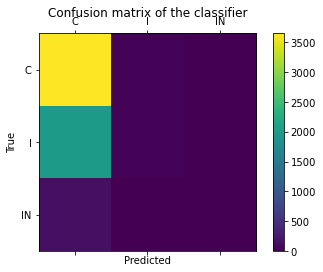

In [19]:
#seperate features and target
X, y = pass_plays[list(set(pass_plays.columns)-{'passResult'})].values, pass_plays.passResult.values
#seperate to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#fit a random forest classifier
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
#predict and evaluate classifier
score = clf.score(X_test, y_test)
print("The accuracy score between predictions and ground truth is = {}% which represents {} plays out of ".format(score*100,
                                        int(len(y_test)*score)), len(y_test))

labels = ['C', 'I', 'IN']
cm = confusion_matrix(pass_res_le.inverse_transform(y_test),pass_res_le.inverse_transform(clf.predict(X_test)), labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

=> The classifier classifies most of the plays as successful passes eventhough it's not the case therefore it's not very accurate and to be tuned (if not discarded)

### ***Weeks:***

Load weeks and get a random week number to work on

In [20]:
weeks = {}
for i in range(1,17):
    weeks[i] =  pd.read_csv(f'/kaggle/input/nfl-big-data-bowl-2021/week{i}.csv')
    weeks[i].set_index(['gameId', 'playId', 'frameId'], inplace=True)

In [21]:
week_nbr = np.random.randint(1,17)
week = weeks[week_nbr].drop('jerseyNumber', axis=1)
week.time = pd.to_datetime(week.time)
print(f"The number of play frames in week {week_nbr} is {len(week)}")
week.head()

The number of play frames in week 14 is 1161644


time      x      y  \
gameId     playId frameId                                                  
2018120600 83     1       2018-12-07 01:23:42.599000+00:00  85.79  25.06   
                  1       2018-12-07 01:23:42.599000+00:00  68.51  21.01   
                  1       2018-12-07 01:23:42.599000+00:00  79.59  17.14   
                  1       2018-12-07 01:23:42.599000+00:00  76.54   8.66   
                  1       2018-12-07 01:23:42.599000+00:00  75.82  28.98   

                              s     a   dis       o     dir event      nflId  \
gameId     playId frameId                                                      
2018120600 83     1        0.00  0.00  0.00  292.51  253.38  None  2495469.0   
                  1        1.67  1.10  0.16  111.50  162.72  None  2532848.0   
                  1        0.99  1.23  0.09   56.50  327.54  None  2539237.0   
                  1        0.56  0.31  0.06   13.56  248.81  None  2541162.0   
                  1        0.36  1.53  0.04  119.68   62.39  None  2543711.0   

                              displayName position  team playDirection route  
gameId     playId frameId                                                     
2018120600 83     1            Dion Lewis       RB  home          left  FLAT  
                  1        Tashaun Gipson       FS  away          left   NaN  
                  1           D.J. Hayden       CB  away          left   NaN  
                  1            A.J. Bouye       CB  away          left   NaN  
                  1          Telvin Smith      OLB  away          left   NaN

animate frames of a randomly picked play

In [22]:
index = np.random.choice(week.index)[0:2]
play = week.loc[index]

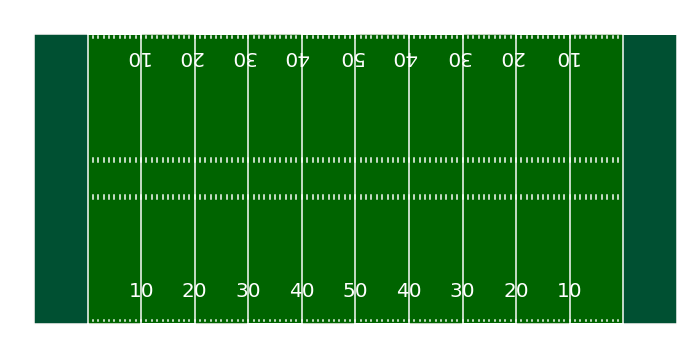

In [23]:
import matplotlib.animation as animation

fig, ax = create_football_field()
frame = play.loc[1]
homePlayers, = ax.plot(frame[frame.team == 'home'].x.values, frame[frame.team == 'home'].y.values, 'r*', ms=6)
awayPlayers, = ax.plot(frame[frame.team == 'home'].x.values, frame[frame.team == 'home'].y.values, 'b*', ms=6)
football, = ax.plot(frame[frame.team == 'home'].x.values, frame[frame.team == 'home'].y.values, 'y*', ms=6)

play = week.loc[index]

def init():
    """initialize animation"""
    global homePlayers, awayPlayers, football
    homePlayers.set_data([], [])
    awayPlayers.set_data([], [])
    football.set_data([], [])
    return homePlayers, awayPlayers, football

def animate(i):
    """perform animation step"""
    global homePlayers, awayPlayers, football, play
    frame = play.loc[(i%max(play.index))+1]
    # update pieces of the animation
    homePlayers.set_data(frame[frame.team == 'home'].x.values, frame[frame.team == 'home'].y.values)
    awayPlayers.set_data(frame[frame.team == 'away'].x.values, frame[frame.team == 'away'].y.values)
    football.set_data(frame[frame.team == 'football'].x.values, frame[frame.team == 'football'].y.values)
    return homePlayers, awayPlayers, football

ani = animation.FuncAnimation(fig, animate, frames=100,
                              interval=1, blit=False, init_func=init)


plt.show()

after 2s from ball snap
		* player Robert Woods playing with away team as a WR is at a minimal distance of 12.767697521479743 to the opposite team where the closest defender is Kyle Fuller playng as CB
		* player Brandin Cooks playing with away team as a WR is at a minimal distance of 1.0159232254457018 to the opposite team where the closest defender is Prince Amukamara playng as CB
		* player Todd Gurley playing with away team as a RB is at a minimal distance of 8.254659290364446 to the opposite team where the closest defender is Leonard Floyd playng as OLB
		* player Jared Goff playing with away team as a QB is at a minimal distance of 10.390654454845473 to the opposite team where the closest defender is Leonard Floyd playng as OLB
		* player Gerald Everett playing with away team as a TE is at a minimal distance of 9.788059051722156 to the opposite team where the closest defender is Danny Trevathan playng as ILB
		* player Josh Reynolds playing with away team as a WR is at a minimal 

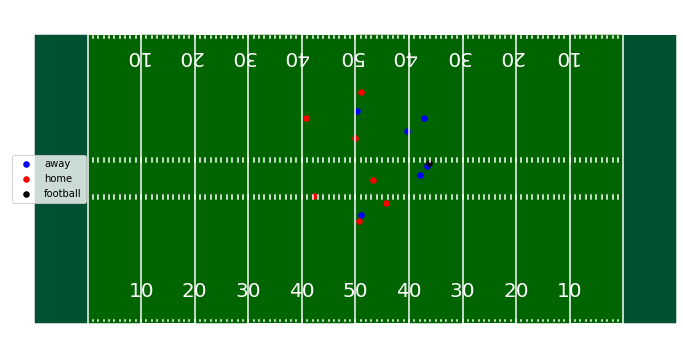

after 3s from ball snap
		* player Robert Woods playing with away team as a WR is at a minimal distance of 13.34623917064279 to the opposite team where the closest defender is Kyle Fuller playng as CB
		* player Brandin Cooks playing with away team as a WR is at a minimal distance of 5.004647839758557 to the opposite team where the closest defender is Prince Amukamara playng as CB
		* player Todd Gurley playing with away team as a RB is at a minimal distance of 5.724561118548737 to the opposite team where the closest defender is Leonard Floyd playng as OLB
		* player Jared Goff playing with away team as a QB is at a minimal distance of 13.599529403622755 to the opposite team where the closest defender is Leonard Floyd playng as OLB
		* player Gerald Everett playing with away team as a TE is at a minimal distance of 15.936000125502014 to the opposite team where the closest defender is Roquan Smith playng as LB
		* player Josh Reynolds playing with away team as a WR is at a minimal dista

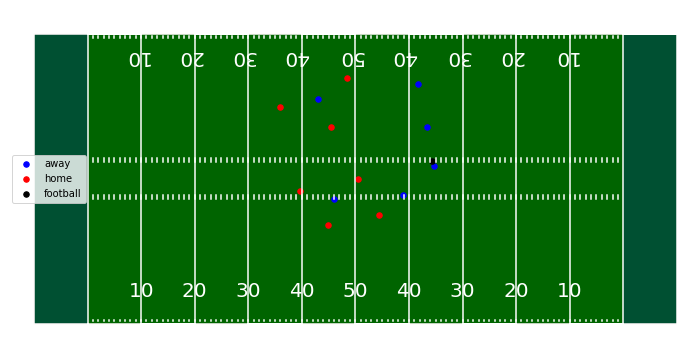

after 3500ms from ball snap
		* player Robert Woods playing with away team as a WR is at a minimal distance of 13.211093822995878 to the opposite team where the closest defender is Kyle Fuller playng as CB
		* player Brandin Cooks playing with away team as a WR is at a minimal distance of 4.092163242100684 to the opposite team where the closest defender is Roquan Smith playng as LB
		* player Todd Gurley playing with away team as a RB is at a minimal distance of 4.323251091481972 to the opposite team where the closest defender is Leonard Floyd playng as OLB
		* player Jared Goff playing with away team as a QB is at a minimal distance of 14.659566842168294 to the opposite team where the closest defender is Leonard Floyd playng as OLB
		* player Gerald Everett playing with away team as a TE is at a minimal distance of 18.06231435890761 to the opposite team where the closest defender is Roquan Smith playng as LB
		* player Josh Reynolds playing with away team as a WR is at a minimal dista

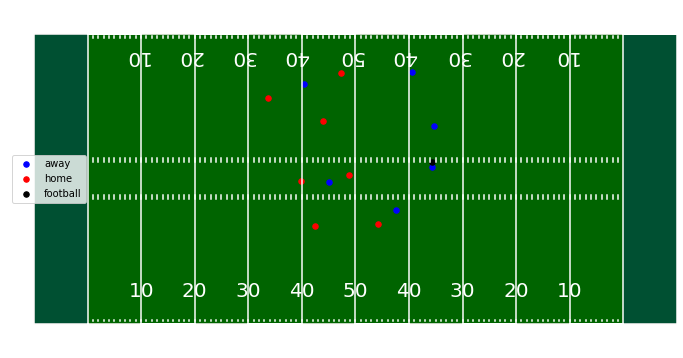

after 4s from ball snap
		* player Robert Woods playing with away team as a WR is at a minimal distance of 12.878881939050451 to the opposite team where the closest defender is Kyle Fuller playng as CB
		* player Brandin Cooks playing with away team as a WR is at a minimal distance of 3.445954149433796 to the opposite team where the closest defender is Roquan Smith playng as LB
		* player Todd Gurley playing with away team as a RB is at a minimal distance of 3.0295214143491282 to the opposite team where the closest defender is Leonard Floyd playng as OLB
		* player Jared Goff playing with away team as a QB is at a minimal distance of 15.944293650080583 to the opposite team where the closest defender is Leonard Floyd playng as OLB
		* player Gerald Everett playing with away team as a TE is at a minimal distance of 19.583569643964296 to the opposite team where the closest defender is Roquan Smith playng as LB
		* player Josh Reynolds playing with away team as a WR is at a minimal distanc

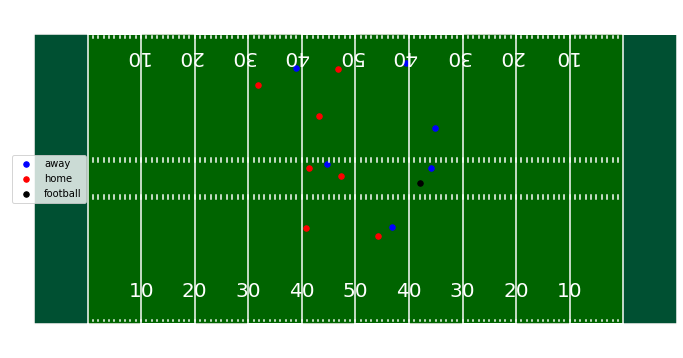

after 4500ms from ball snap
		* player Robert Woods playing with away team as a WR is at a minimal distance of 12.459253589200282 to the opposite team where the closest defender is Kyle Fuller playng as CB
		* player Brandin Cooks playing with away team as a WR is at a minimal distance of 2.3743841306747324 to the opposite team where the closest defender is Eddie Jackson playng as FS
		* player Todd Gurley playing with away team as a RB is at a minimal distance of 1.623483908143219 to the opposite team where the closest defender is Leonard Floyd playng as OLB
		* player Jared Goff playing with away team as a QB is at a minimal distance of 16.99059739973848 to the opposite team where the closest defender is Leonard Floyd playng as OLB
		* player Gerald Everett playing with away team as a TE is at a minimal distance of 20.49124935185749 to the opposite team where the closest defender is Roquan Smith playng as LB
		* player Josh Reynolds playing with away team as a WR is at a minimal dist

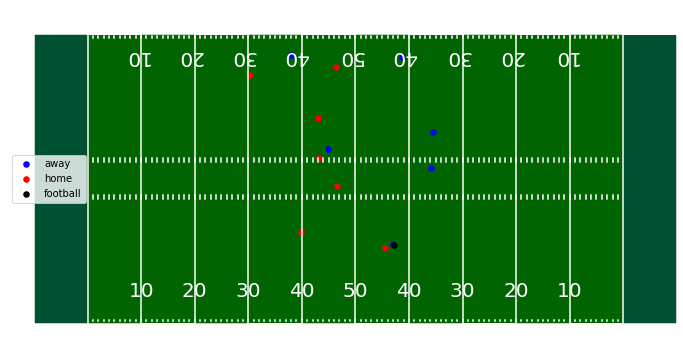

In [24]:
#calculate minimal distance for each offense player with defenders (0.5 seconds after ball snap)
for delta in ["2s", "3s", "3500ms", "4s", "4500ms"]:
    print("after {} from ball snap".format(delta))
    ballSnap_shifted = week[week.event == 'ball_snap'].loc[index].time.unique()[0] + pd.Timedelta(delta)
    frame_id = list(week[(week.time < ballSnap_shifted)].loc[index].index).pop()
    frame = week.loc[index[0], index[1], frame_id]
    fig, ax = create_football_field()
    attack_players = frame[frame.team == frame[(frame.position == 'QB') ].team.values[0]].set_index('nflId', append=True)
    defense_players = frame[frame.team == ((set(frame.team) - set(frame[(frame.position == 'QB') ].team.values))-{'football'}).pop()].set_index('nflId', append=True)
    for id_attack in attack_players.index:
        play_attack = attack_players.loc[id_attack]
        min_dis, closest_defender = 100, None
        for id_defense in defense_players.index:
            play_defense = defense_players.loc[id_defense]
            dis = np.sqrt((play_attack.x - play_defense.x)**2 + (play_attack.y - play_defense.y)**2)
            if(dis < min_dis):
                min_dis, closest_defender = dis, play_defense.copy()
        print(f"\t\t* player {play_attack.displayName} playing with {play_attack.team} team as a {play_attack.position} is at a minimal distance of {min_dis} to "+ 
              f"the opposite team where the closest defender is {closest_defender.displayName} playng as {closest_defender.position}")
    print("\n")
    frame[frame.team == 'away'].plot(x='x', y='y', kind='scatter', ax=ax, s=30, color='blue', label='away')
    frame[frame.team == 'home'].plot(x='x', y='y', kind='scatter', ax=ax, s=30, color='red', label='home')
    frame[frame.team == 'football'].plot(x='x', y='y', kind='scatter', ax=ax, s=30, color='black', label='football')
    plt.legend(loc='best')
    plt.show()

In [25]:
week.loc[index].event.unique()

array(['man_in_motion', 'None', 'ball_snap', 'play_action',
       'pass_forward', 'pass_arrived', 'pass_outcome_caught',
       'first_contact', 'out_of_bounds'], dtype=object)

A classifier to decide the type of play (P: Pass, S: Sack, R: Running) depending on features below:
* offense formation
* offense taken route from the list of routes in constants' section above
* minimal distance between quarterback and defense (after 1.5s from ball snap)
* minimal and maximal distance between the defense and the offense team (after 1.5s from ball snap)

In [27]:
#get the play type (sack, pass, running)
play_type_df = pd.DataFrame(index = week.index, columns=['playType', 'QB_min_dis_defense', 'offense_min_dis_defense', 'offense_max_dis_defense', 'formation'])
play_type_df.reset_index(level='frameId', drop=True, inplace=True)
play_type_df = play_type_df[~play_type_df.index.duplicated(keep='first')]
for route in routes:
    play_type_df['is_'+route+'route'] = 0
for id in play_type_df.index:
    #update play type
    if(any('sack' in event for event in week.loc[id].event.unique())):
       play_type_df.loc[id, 'playType'] = 'S'
    elif(any('pass' in event or 'qb_spike' in event for event in week.loc[id].event.unique())):
       play_type_df.loc[id, 'playType'] = 'P'
    else:
       play_type_df.loc[id, 'playType'] = 'R'
    #update route
    for route in week.loc[id].route.unique():
        if(route in routes):
            play_type_df.loc[id, 'is_'+route+'route'] = 1
    #update formation
    try:
        play_type_df.loc[id, 'formation'] = plays.loc[id].offenseFormation
    except:
        play_type_df.loc[id, 'formation'] = 'None'
    #update min distances
    ballSnap_shifted = week[week.event == 'ball_snap'].loc[id].time.unique()[0] + pd.Timedelta("1500ms")
    frame_id = list(week[(week.time < ballSnap_shifted)].loc[id].index).pop()
    frame = week.loc[id[0], id[1], frame_id]
    try:
        attack_players = frame[frame.team == frame[(frame.position == 'QB') ].team.values[0]].set_index('nflId', append=True)
    except:
        attack_players = pd.DataFrame()
    try:
        defense_players = frame[frame.team == ((set(frame.team) - set(frame[(frame.position == 'QB') ].team.values))-{'football'}).pop()].set_index('nflId', append=True)
    except:
        defense_players = pd.DataFrame()
    min_dis, min_dis_qb, max_dis = 100, 100, 0
    for id_attack in attack_players.index:
        play_attack = attack_players.loc[id_attack]
        min_dis = 100
        for id_defense in defense_players.index:
            play_defense = defense_players.loc[id_defense]
            dis = np.sqrt((play_attack.x - play_defense.x)**2 + (play_attack.y - play_defense.y)**2)
            try:
                if(dis < min_dis):
                    min_dis = dis
                if(dis > max_dis):
                    max_dis = dis
                if(dis < min_dis_qb and play_attack.position == 'QB'):
                    min_dis_qb = dis
            except:
                pass
    play_type_df.loc[id, ['QB_min_dis_defense', 'offense_min_dis_defense', 'offense_max_dis_defense']] = [min_dis_qb, min_dis, max_dis]
#encode formations
formation_le = LabelEncoder()
def preprocess_formation(x):
    try:
        return str(x)
    except:
        return 'None'
play_type_df.formation = play_type_df.formation.apply(lambda x: preprocess_formation(x))
play_type_df.formation = formation_le.fit_transform(play_type_df.formation)
#encode play Types
playType_le = LabelEncoder()
play_type_df.playType = playType_le.fit_transform(play_type_df.playType)
play_type_df.head()

playType QB_min_dis_defense offense_min_dis_defense  \
gameId     playId                                                        
2018120600 83             0            9.83456                 2.48966   
           136            0            10.2047                 2.84007   
           183            0            9.27533                 2.08389   
           208            0            6.72402                 3.79269   
           347            0            6.48214                0.693542   

                  offense_max_dis_defense  formation  is_ANGLEroute  \
gameId     playId                                                     
2018120600 83                     27.1715          4              0   
           136                    28.9783          5              0   
           183                    33.7423          1              1   
           208                      24.26          1              0   
           347                    27.2563          4              0   

                   is_CORNERroute  is_CROSSroute  is_FLATroute  is_GOroute  \
gameId     playId                                                            
2018120600 83                   1              1             1           0   
           136                  0              0             0           1   
           183                  0              0             1           1   
           208                  1              0             1           0   
           347                  0              0             1           1   

                   is_HITCHroute  is_INroute  is_OUTroute  is_POSTroute  \
gameId     playId                                                         
2018120600 83                  1           0            0             0   
           136                 0           0            0             1   
           183                 0           0            0             0   
           208                 0           0            0             1   
           347                 1           0            0             0   

                   is_SCREENroute  is_SLANTroute  is_WHEELroute  
gameId     playId                                                
2018120600 83                   0              0              0  
           136                  1              0              0  
           183                  0              0              0  
           208                  0              0              0  
           347                  0              0              0

In [28]:
corr = play_type_df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,playType,formation,is_ANGLEroute,is_CORNERroute,is_CROSSroute,is_FLATroute,is_GOroute,is_HITCHroute,is_INroute,is_OUTroute,is_POSTroute,is_SCREENroute,is_SLANTroute,is_WHEELroute
playType,1.000000,0.030206,-0.107812,-0.107085,-0.169964,-0.250234,-0.259462,-0.227994,-0.149140,-0.191214,-0.146122,-0.105257,-0.125446,-0.042819
formation,0.030206,1.000000,0.060640,0.038469,0.091025,0.068828,-0.077722,-0.043469,-0.021320,-0.003816,-0.065021,-0.069762,-0.133342,0.030688
is_ANGLEroute,-0.107812,0.060640,1.000000,-0.015628,-0.100760,-0.120649,0.062495,0.073121,-0.047611,0.008539,0.009060,-0.017807,0.001824,-0.065813
is_CORNERroute,-0.107085,0.038469,-0.015628,1.000000,0.057840,0.129534,-0.169066,-0.075481,0.115202,0.081744,0.006123,-0.091796,-0.057047,-0.020347
is_CROSSroute,-0.169964,0.091025,-0.100760,0.057840,1.000000,0.052739,-0.032017,-0.150270,0.069899,0.039464,0.098970,-0.044361,-0.103032,0.091299
is_FLATroute,-0.250234,0.068828,-0.120649,0.129534,0.052739,1.000000,-0.033271,0.095493,0.041603,-0.064783,-0.023151,0.008181,0.101358,-0.079621
is_GOroute,-0.259462,-0.077722,0.062495,-0.169066,-0.032017,-0.033271,1.000000,0.034310,-0.001886,-0.011142,0.054084,0.099161,0.050096,-0.022760
is_HITCHroute,-0.227994,-0.043469,0.073121,-0.075481,-0.150270,0.095493,0.034310,1.000000,-0.041636,-0.043738,0.008326,-0.090332,-0.042601,0.082329
is_INroute,-0.149140,-0.021320,-0.047611,0.115202,0.069899,0.041603,-0.001886,-0.041636,1.000000,0.091539,0.034648,-0.117401,-0.112715,-0.054446
is_OUTroute,-0.191214,-0.003816,0.008539,0.081744,0.039464,-0.064783,-0.011142,-0.043738,0.091539,1.000000,-0.013555,-0.100282,-0.060015,-0.039802


The accuracy score between predictions and ground truth is = 94.27860696517413% which represents 379 plays out of  402


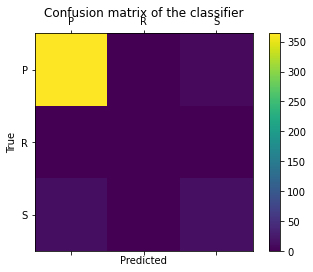

In [29]:
#seperate features and target
X, y = play_type_df[list(set(play_type_df.columns)-{'playType'})].values, play_type_df.playType.values
#seperate to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#fit a random forest classifier
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
#predict and evaluate classifier
score = clf.score(X_test, y_test)
print("The accuracy score between predictions and ground truth is = {}% which represents {} plays out of ".format(score*100,
                                        int(len(y_test)*score)), len(y_test))

labels = list(playType_le.classes_)
cm = confusion_matrix(playType_le.inverse_transform(y_test),playType_le.inverse_transform(clf.predict(X_test)), labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

=> this classifier seem to be working however we cannot confirm its result because of unbalanced classes (use f1_score)
=> this classifier hardly estimates a play as a running due to the lack of running plays' examples

In [30]:
from sklearn.metrics import f1_score
f1_score(y_test, clf.predict(X_test), average='macro')

0.7677059518126774

=> macro avereged f1_score is low 0.56

### ***Touchdown Plays:***

In [31]:
#get the indices of touchdown plays in  the randomly selected week
tchdwn_id = set(week[week.event == 'touchdown'].reset_index(level='frameId').index)
px.histogram(plays.loc[tchdwn_id], x='down', color='quarter', title='The number of touchdown plays per down and quarter')

In [32]:
plays.loc[tchdwn_id].head()

,,timeLeft,quarter,down,possessionTeam,offenseFormation,personnelO,defendersInTheBox,personnelD,playType,yardsToGo,...,typeDropback,preSnapHomeScore,preSnapVisitorScore,offensePlayResult,playResult,epa,isDefensivePenalty,isOffensivePenalty,isSuccessfulPlay,passResult
gameId,playId,,,,,,,,,,,,,,,,,,,,,
2018120906,1183,639,2,1,NE,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,"4 DL, 2 LB, 5 DB",play_type_pass,10,...,TRADITIONAL,14.0,13.0,37,37,3.454117,False,False,S,C
2018120903,4494,18,4,4,ATL,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",play_type_pass,2,...,TRADITIONAL,34.0,14.0,19,19,4.535773,False,False,S,C
2018120912,3723,192,4,1,DAL,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",play_type_pass,10,...,TRADITIONAL,16.0,16.0,75,75,5.558170,False,False,S,C
2018120913,3881,179,4,2,PIT,EMPTY,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",play_type_pass,1,...,TRADITIONAL,17.0,14.0,1,1,1.440666,False,False,S,C
2018120903,314,703,1,1,ATL,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"3 DL, 4 LB, 4 DB",play_type_pass,10,...,TRADITIONAL,0.0,0.0,16,16,2.253569,False,False,S,C
